In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt

# Split sets exploration

In [14]:
database1_source = ['global-bird-zenodo_poland', 'global-bird-zenodo_palmyra', 'global-bird-zenodo_penguins',
                    'global-bird-zenodo_mckellar', 'global-bird-zenodo_newmexico', 
                    'global-bird-zenodo_pfeifer', 'uav-waterfowl-thermal']

original_folder = r'/gpfs/gibbs/project/jetz/eec42/data/original'
source_folder = r'/gpfs/gibbs/project/jetz/eec42/data/formatted_data'
database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/baseline1'
exploration_folder = r'/gpfs/gibbs/project/jetz/eec42/data/baseline1_exploration_27-10-23'

if not os.path.exists(exploration_folder):
    os.mkdir(exploration_folder)

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)

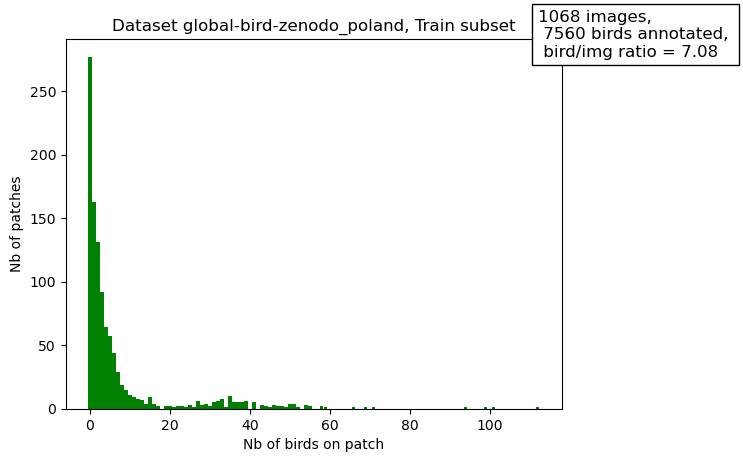

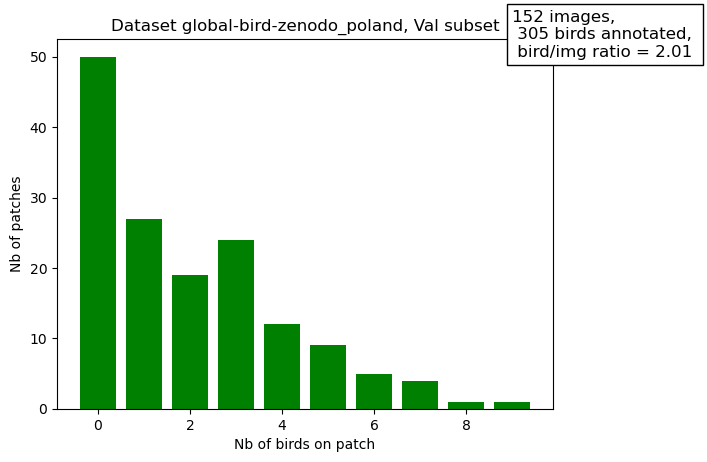

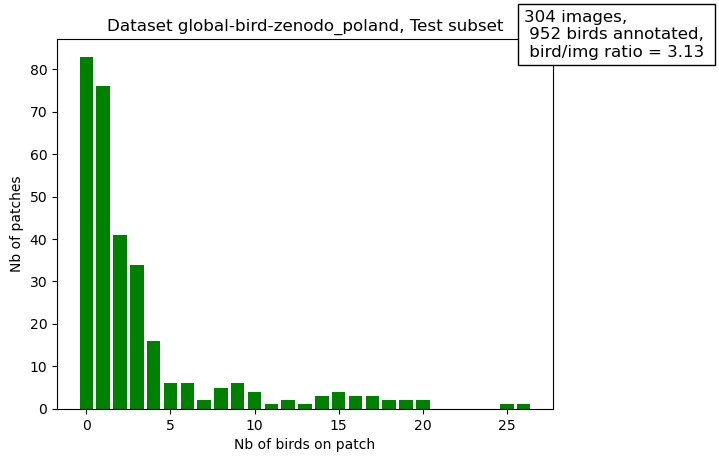

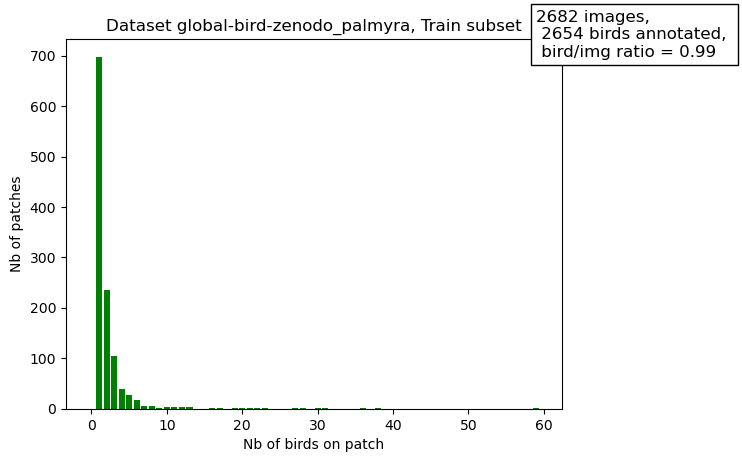

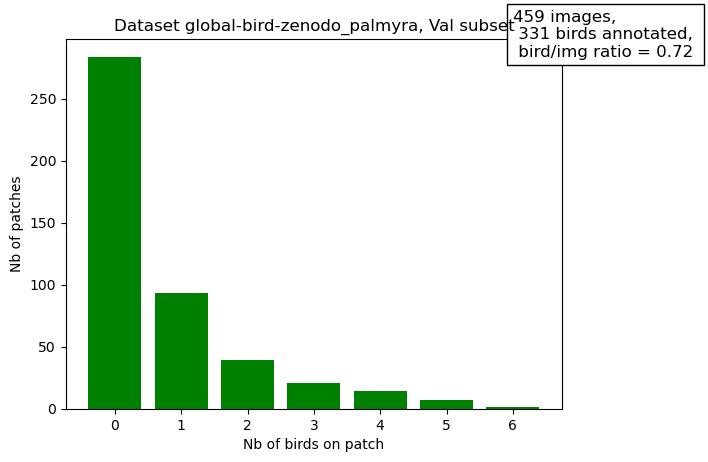

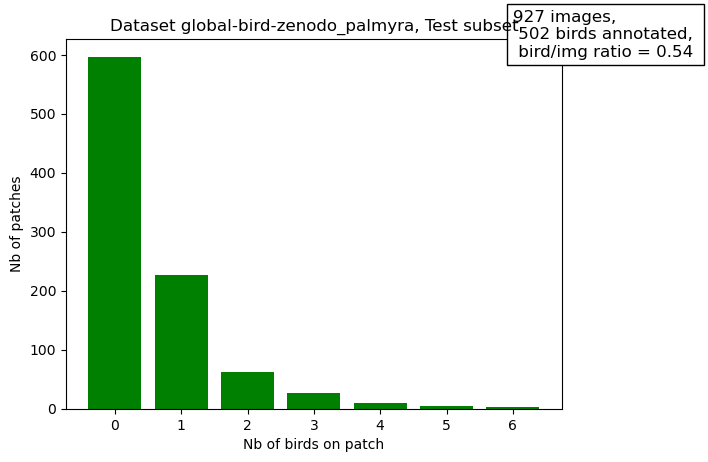

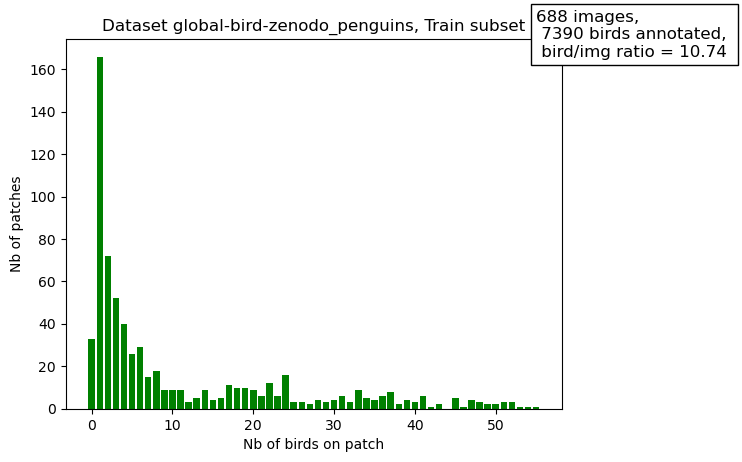

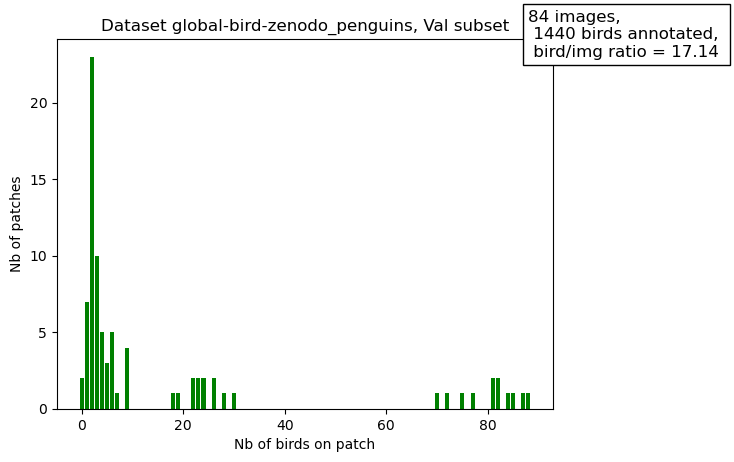

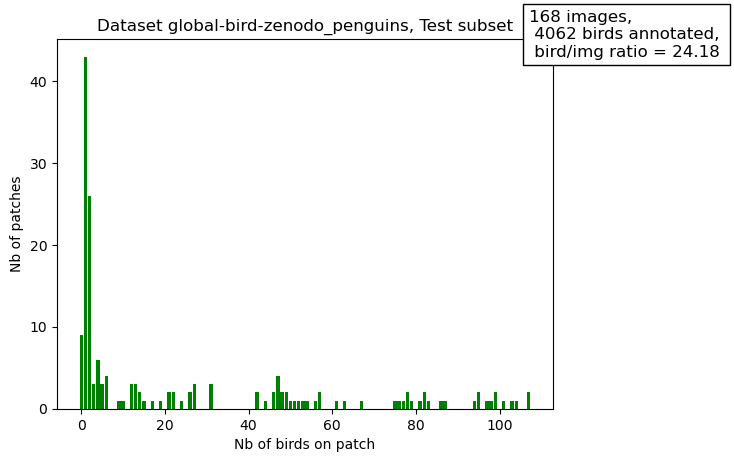

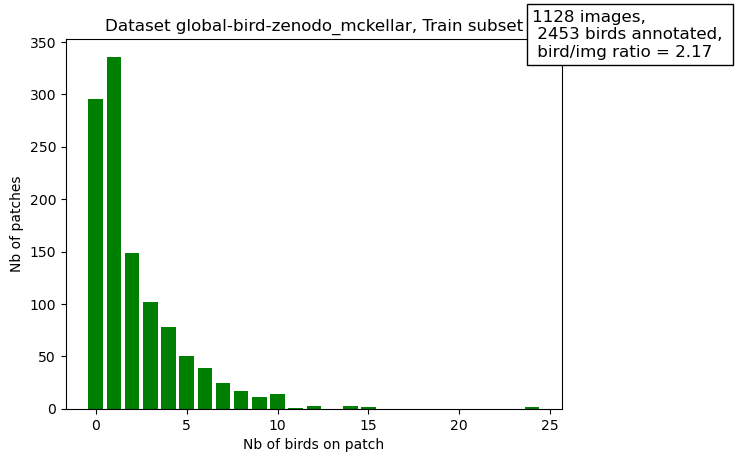

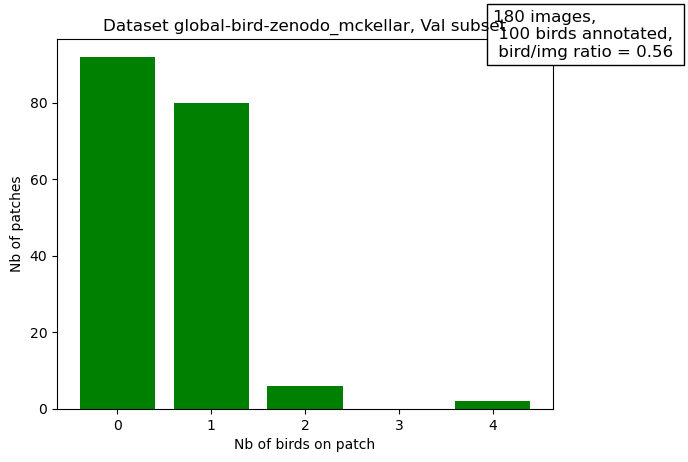

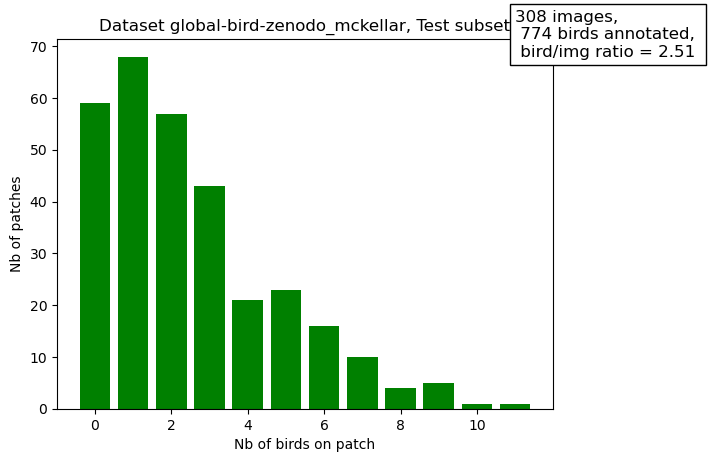

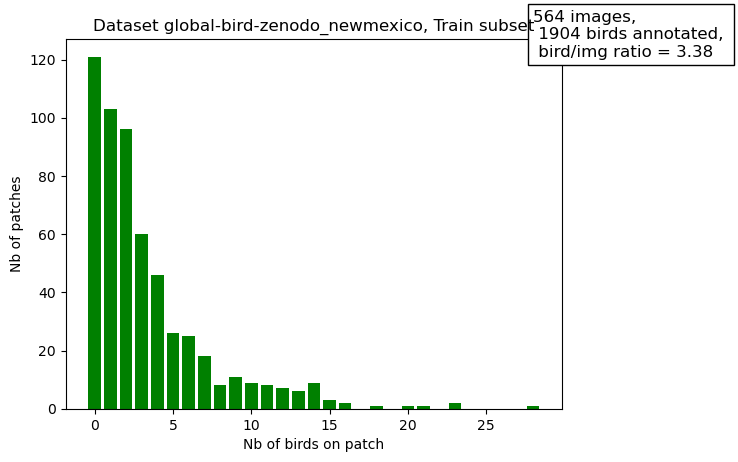

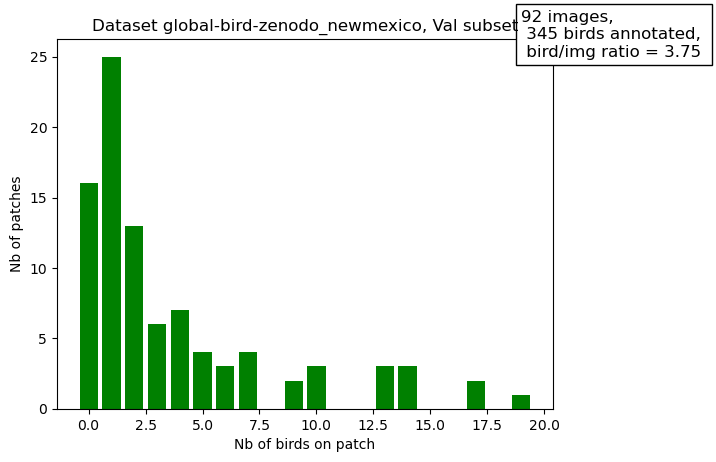

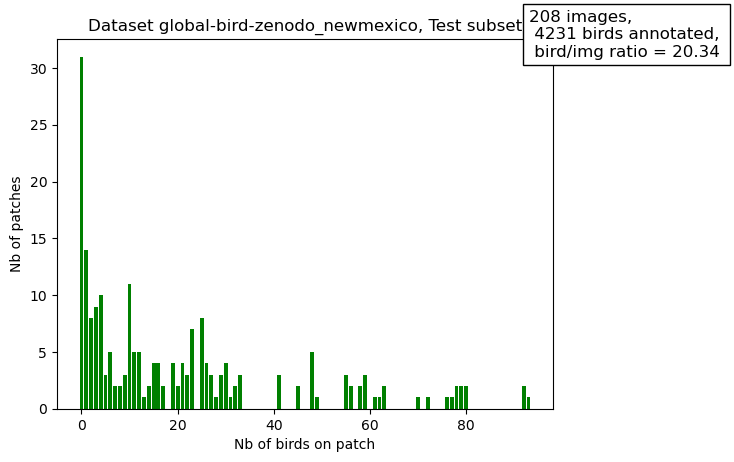

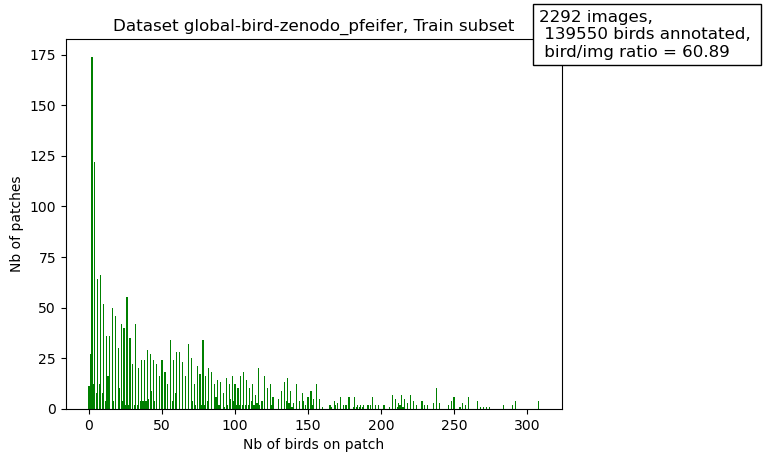

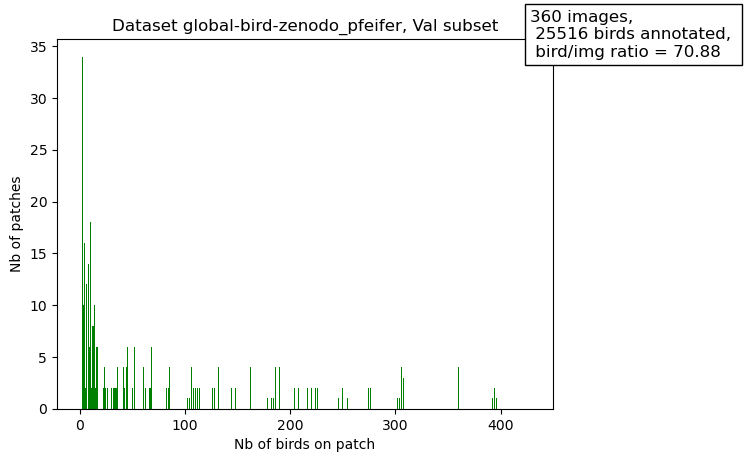

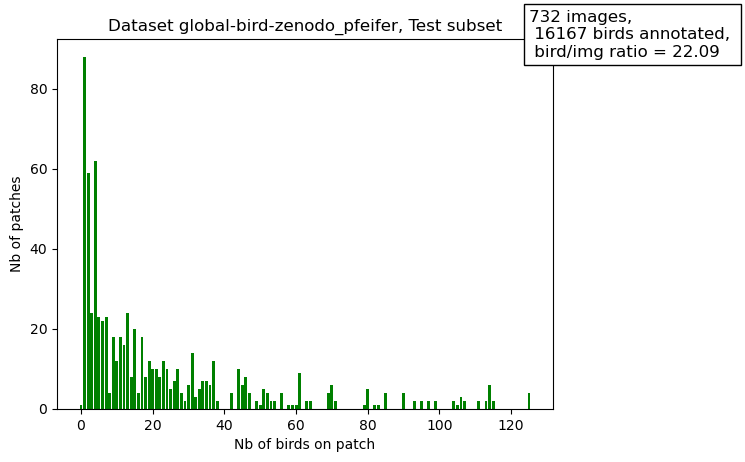

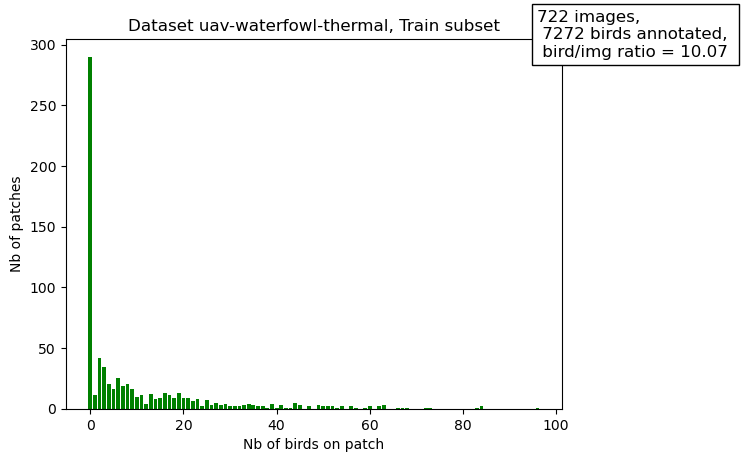

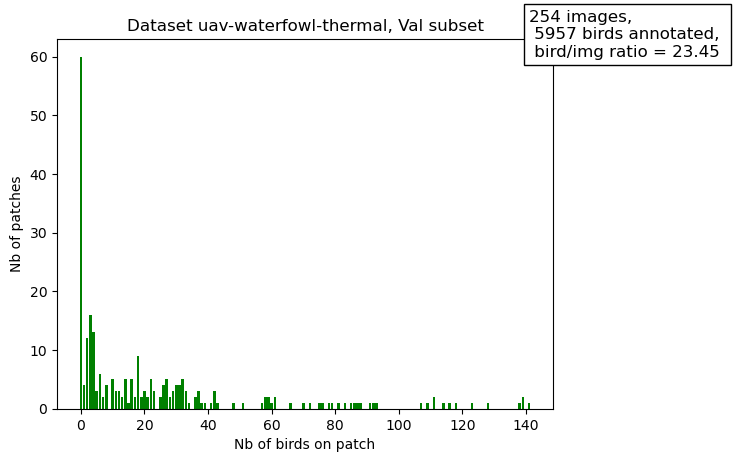

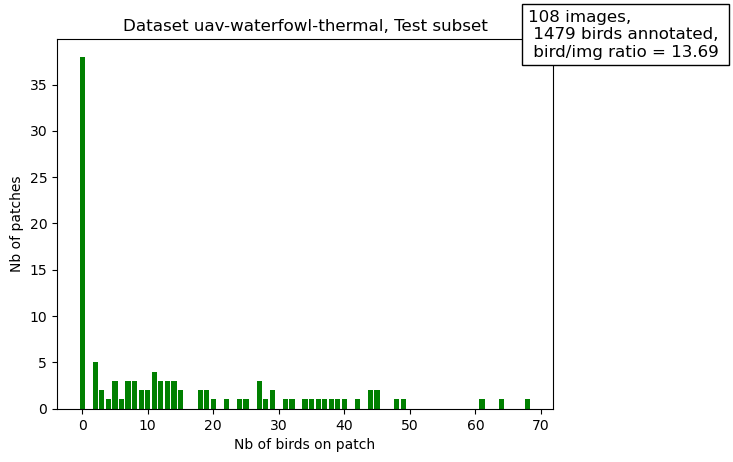

<Figure size 640x480 with 0 Axes>

In [8]:
for dataset in database1_source:

    dataset_stats = stats[dataset]

    for split in ['Train', 'Val', 'Test']:
        birds_repartition = dataset_stats[split]['birds_repartition']
        nb_birds = dataset_stats[split]['nb_birds']
        nb_img =dataset_stats[split]['nb_img']
        nb_background_img = nb_img - sum(birds_repartition.values())
        birds_repartition[0] = nb_background_img
        bird_img_ratio = nb_birds/nb_img

        plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
        plt.title(f'Dataset {dataset}, {split} subset')
        plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
        plt.xlabel('Nb of birds on patch')
        plt.ylabel('Nb of patches')
        plt.show()
        plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))


## **Split sets exploration of the dataset without background images**

In [11]:
database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/baseline1_experiment_no_backgd'

with open(os.path.join(database_folder, 'data_stats.yaml'), "r") as yamlfile:
    stats = yaml.load(yamlfile, Loader=yaml.FullLoader)

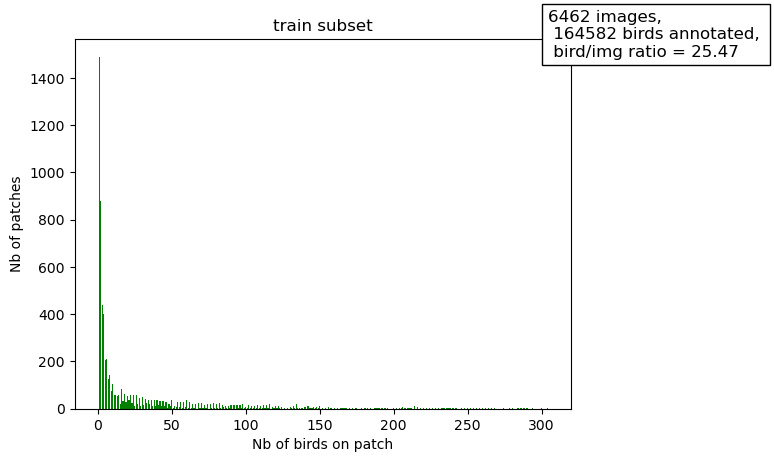

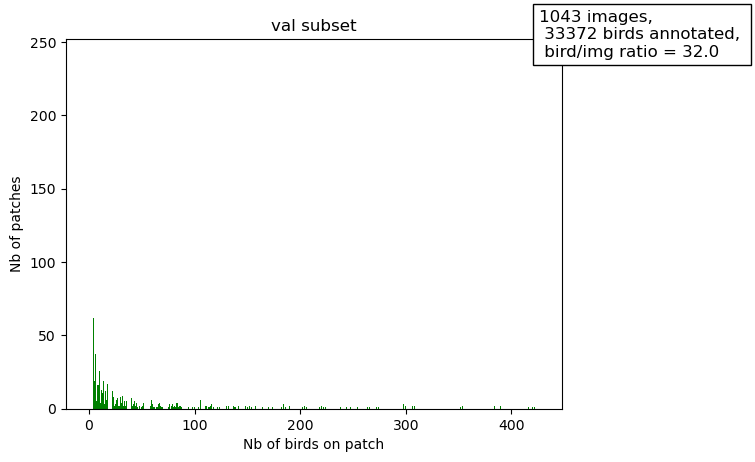

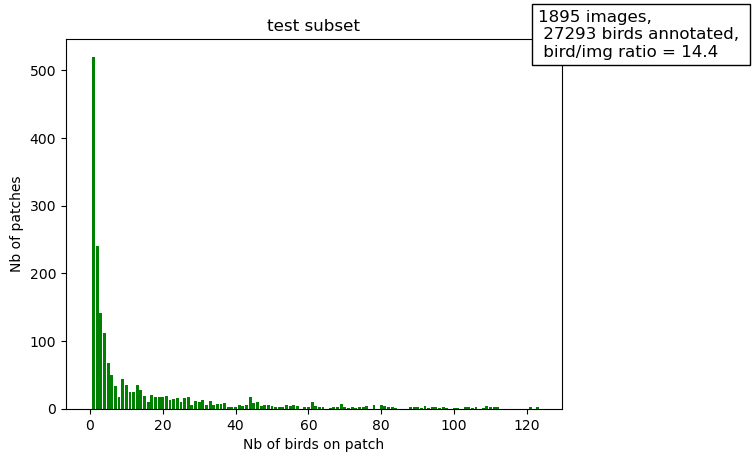

In [12]:
for split in ['train', 'val', 'test']:
    birds_repartition = stats[split]['birds_repartition']
    nb_birds = stats[split]['nb_birds']
    nb_img =stats[split]['nb_img']
    nb_background_img = nb_img - sum(birds_repartition.values())
    birds_repartition[0] = nb_background_img
    bird_img_ratio = nb_birds/nb_img

    plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
    plt.title(f'{split} subset')
    plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
    plt.xlabel('Nb of birds on patch')
    plt.ylabel('Nb of patches')
    plt.show()
    #plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))


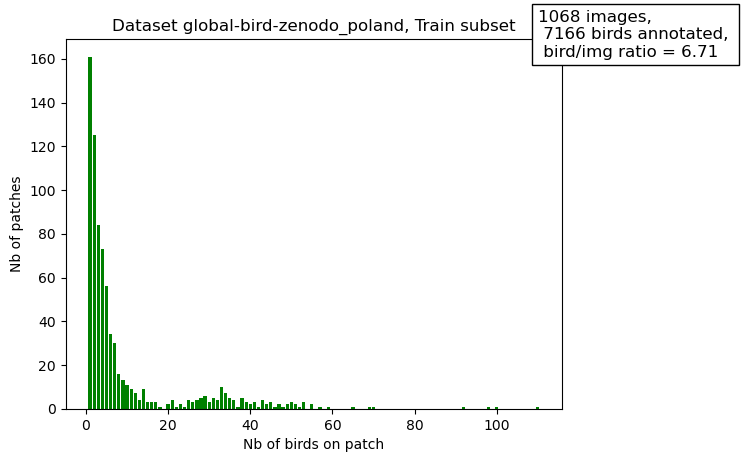

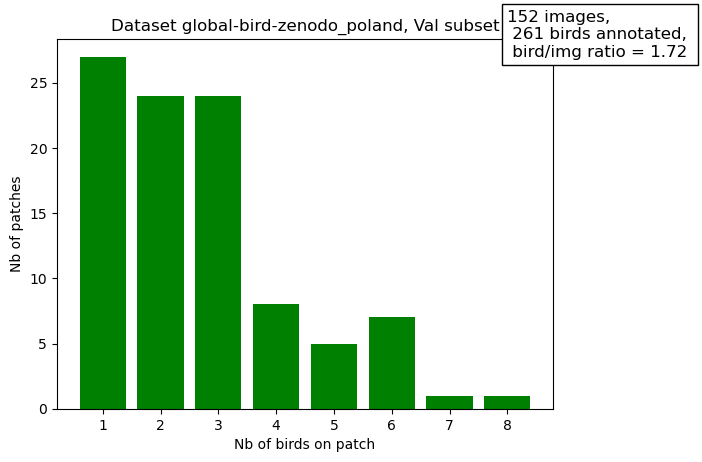

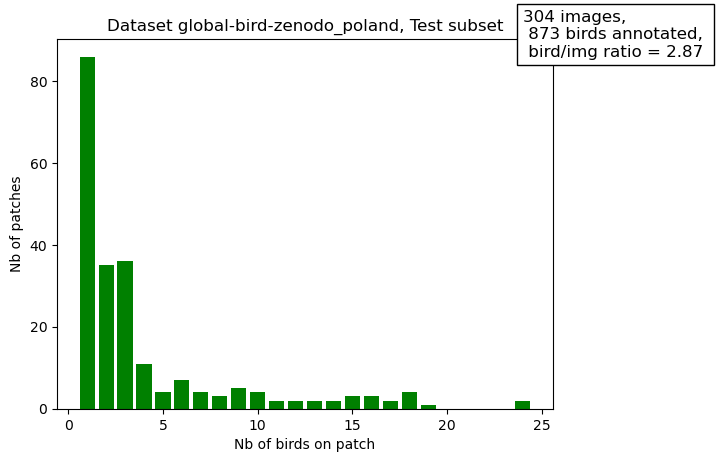

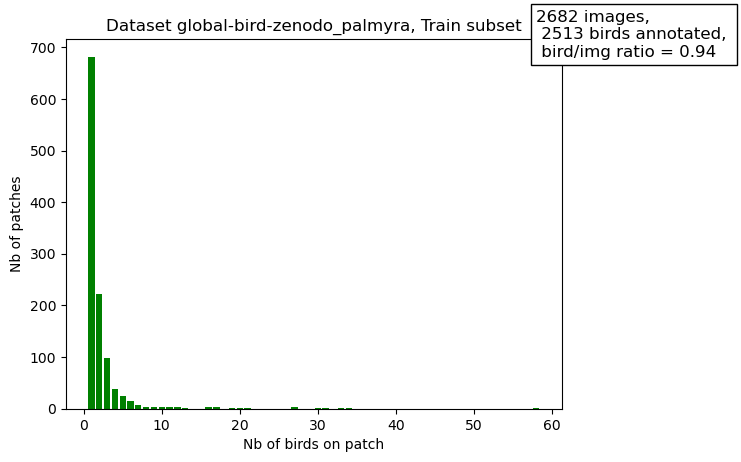

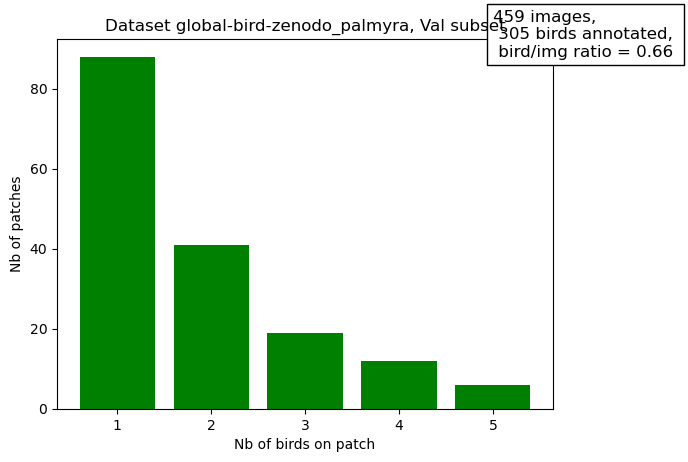

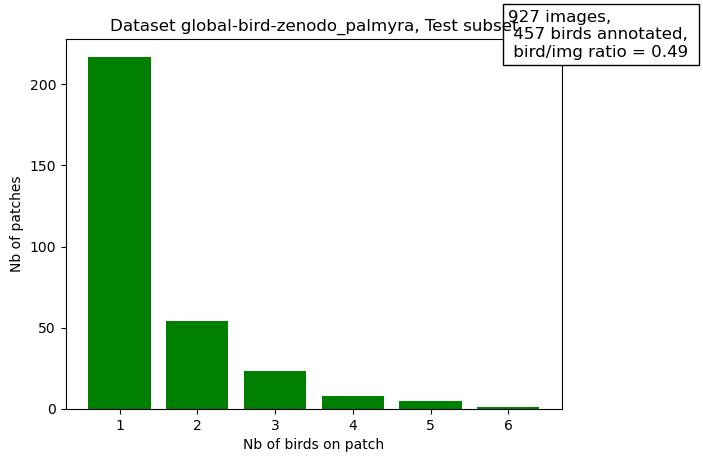

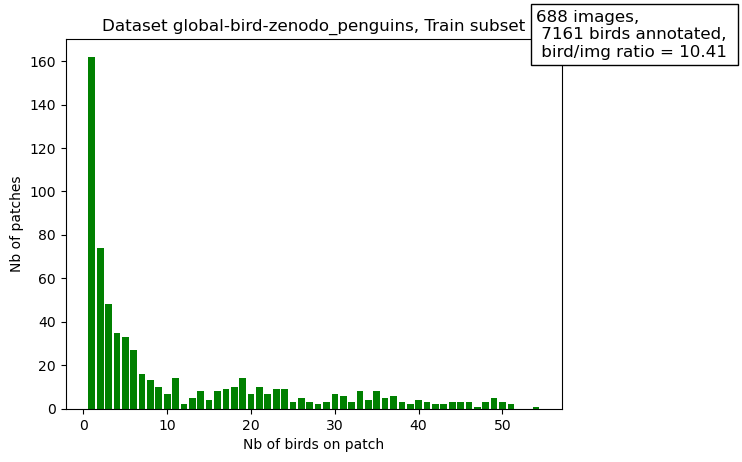

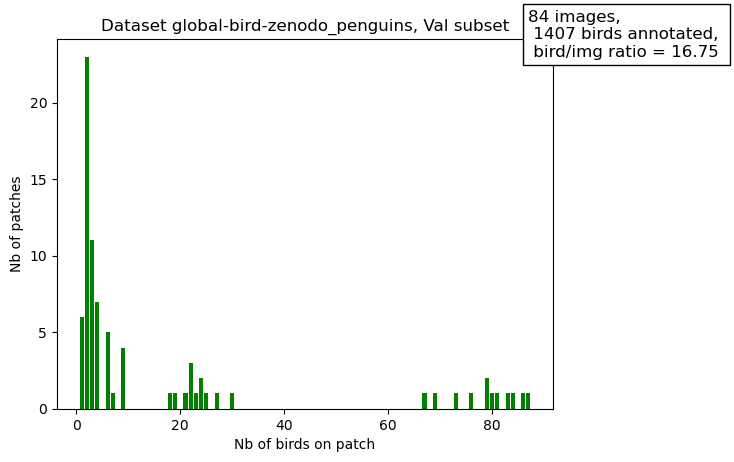

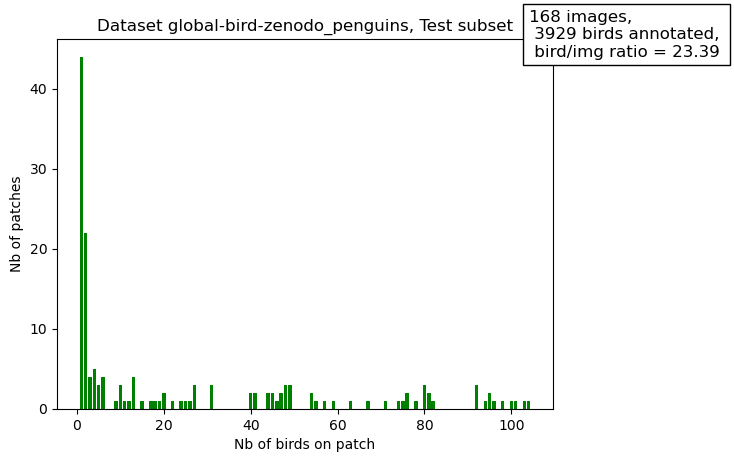

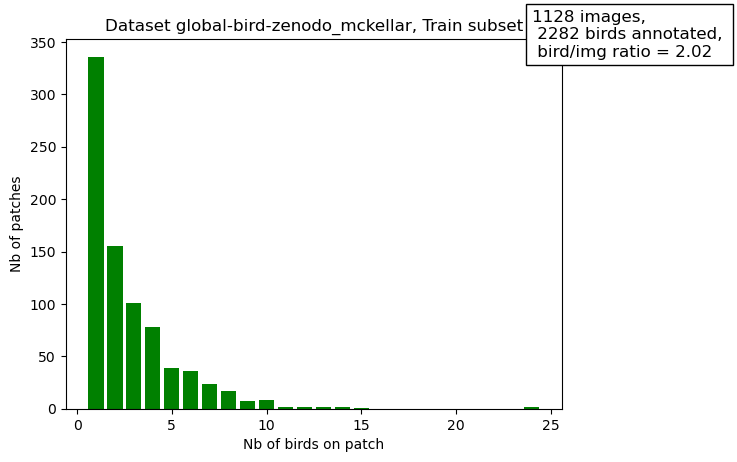

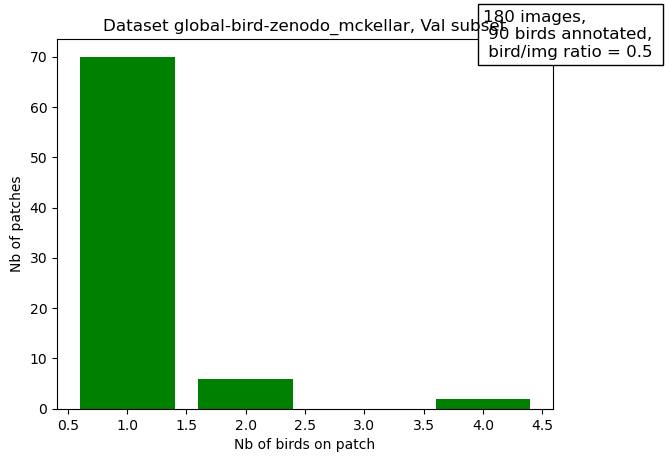

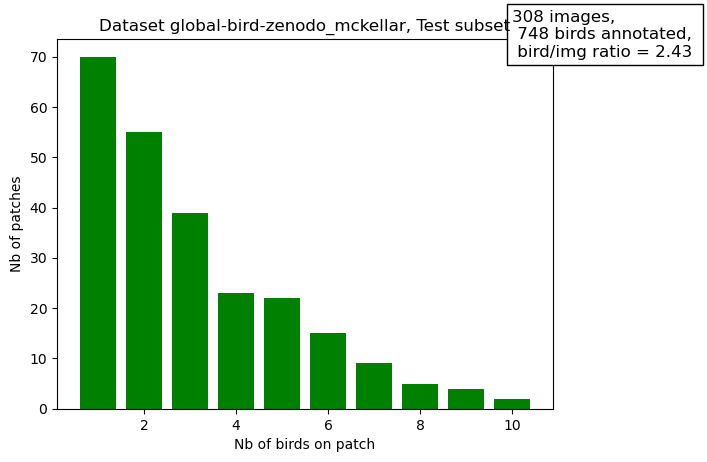

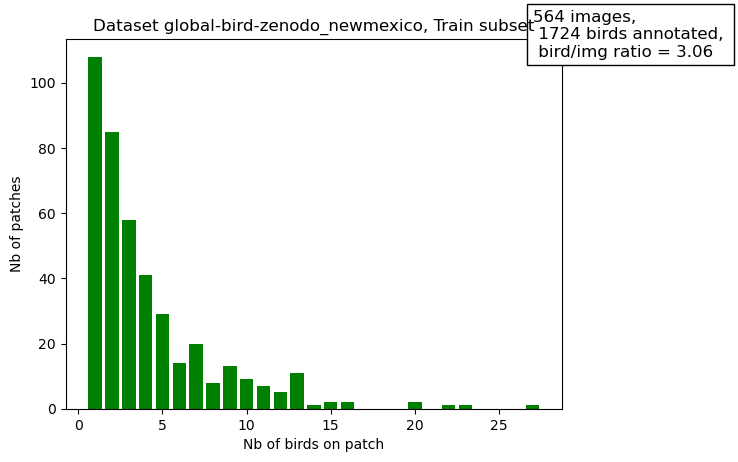

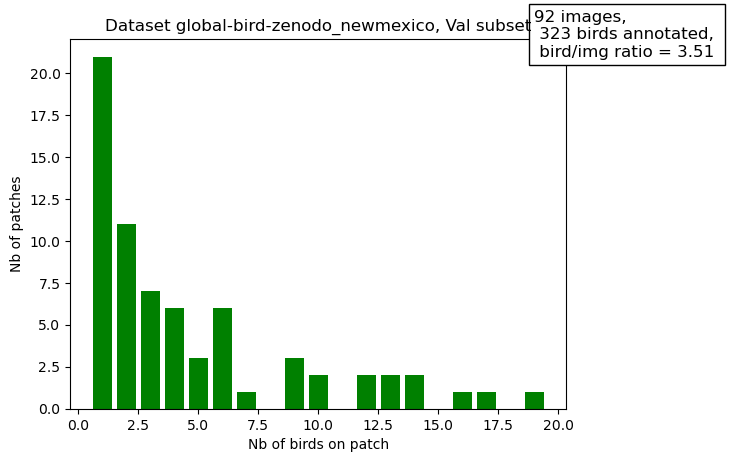

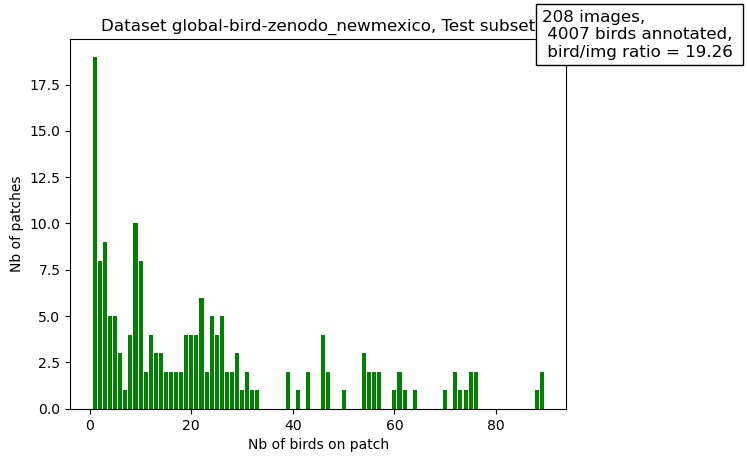

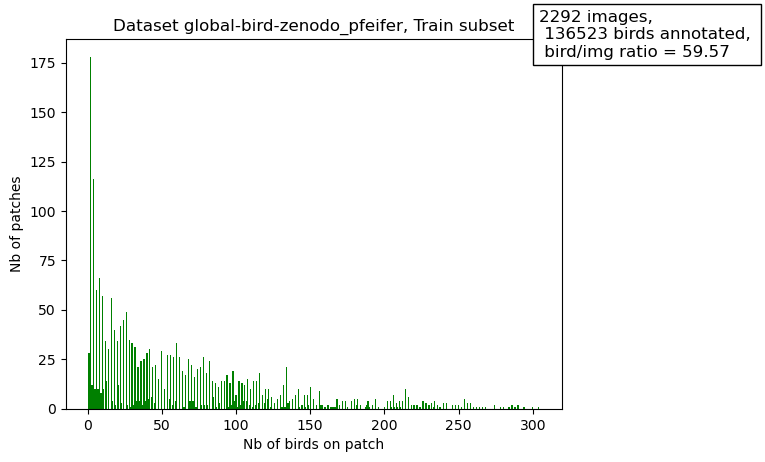

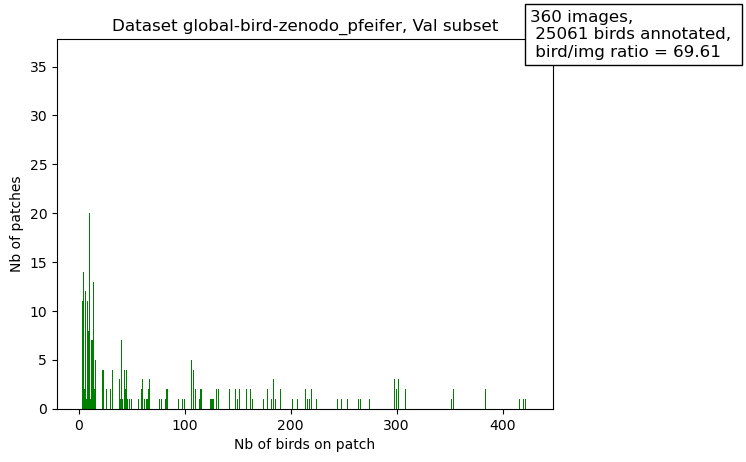

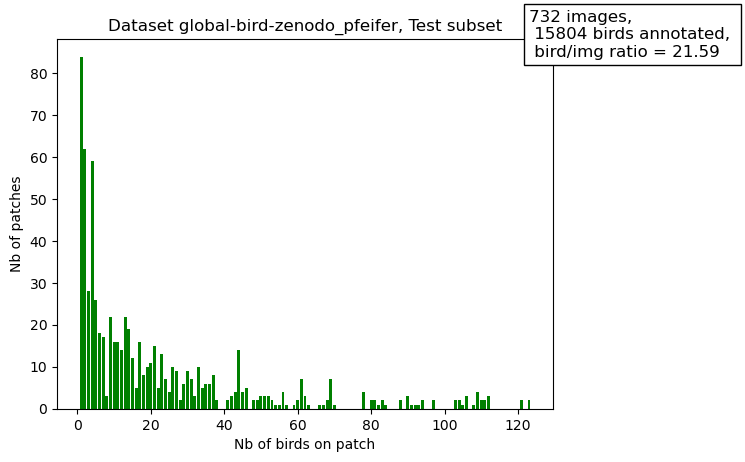

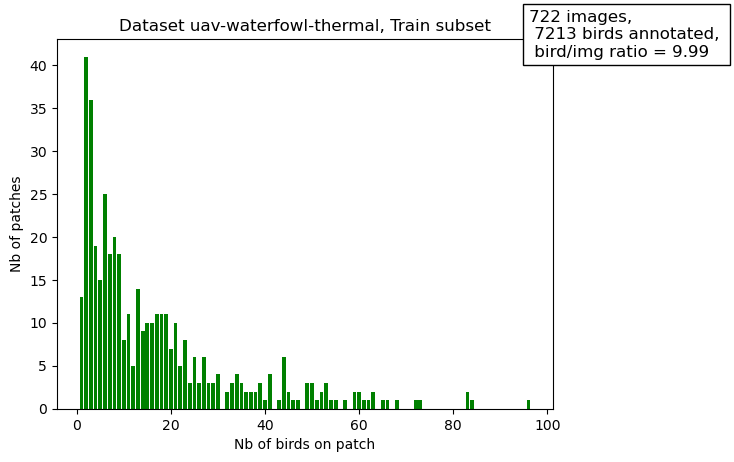

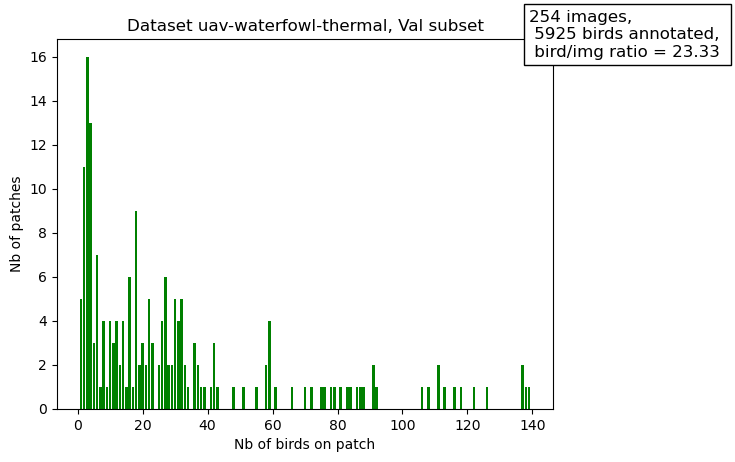

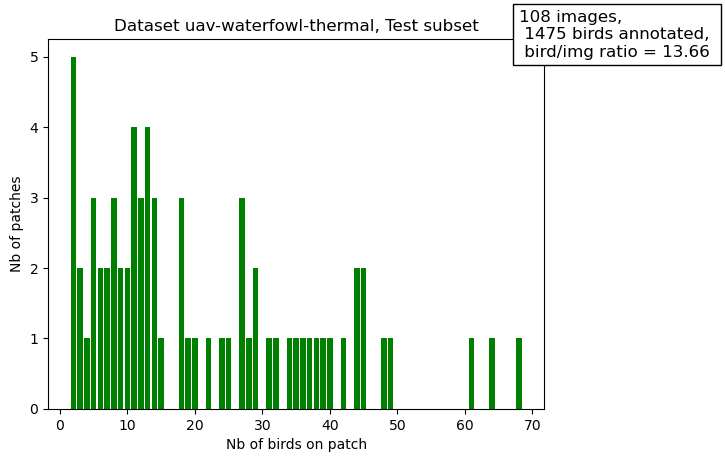

<Figure size 640x480 with 0 Axes>

In [15]:
database_folder = r'/gpfs/gibbs/project/jetz/eec42/data/baseline1_experiment_no_backgd'

for dataset in database1_source:

    dataset_stats = stats[dataset]

    for split in ['Train', 'Val', 'Test']:
        birds_repartition = dataset_stats[split]['birds_repartition']
        nb_birds = dataset_stats[split]['nb_birds']
        nb_img =dataset_stats[split]['nb_img']
        nb_background_img = nb_img - sum(birds_repartition.values())
        bird_img_ratio = nb_birds/nb_img

        plt.bar(list(birds_repartition.keys()), birds_repartition.values(), color='g')
        plt.title(f'Dataset {dataset}, {split} subset')
        plt.text(max(birds_repartition.keys()), max(birds_repartition.values()), f"{nb_img} images, \n {nb_birds} birds annotated, \n bird/img ratio = {str(round(bird_img_ratio, 2))} ", fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))
        plt.xlabel('Nb of birds on patch')
        plt.ylabel('Nb of patches')
        plt.show()
        plt.savefig(os.path.join(exploration_folder, f"stat_{dataset}_split_{split}.png"))
